In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

YEARS = set()

table = dict()
table["population"]  = pd.read_csv("data/population.csv")
table["pcgdp"]       = pd.read_csv("data/pcgdp.csv")
table["gini"]        = pd.read_csv("data/gini.csv")
table["electricity"] = pd.read_csv("data/electricity.csv")
table["life_exp"]    = pd.read_csv("data/life_exp.csv")
winter_raw = pd.read_csv("data/winter.csv")



DROP_FROM = 1960
DROP_TO = 1985
years_to_drop = [str(i) for i in range(DROP_FROM, DROP_TO)]
for key, _ in table.items():
    print(key)
    table[key] = table[key].drop(columns=years_to_drop+[
        "Country Name", "Indicator Name", "Indicator Code",
        "Unnamed: 62", "2017"])
    table[key] = table[key].rename(index=str, columns={"Country Code":"Country"})

population
pcgdp
gini
electricity
life_exp


In [2]:
medals = dict() # by countries code => by years


for i in range(len(winter_raw)):
    row = dict(winter_raw.iloc[i, :])
    ccode = row["Country"]
    year  = row["Year"]
    medal = row["Medal"]
    if int(year) < DROP_TO:
        continue
        
    YEARS.add(year)
    medals.setdefault(ccode, dict()).setdefault(year, 0)
    medals[ccode][year] += 1
print("total country medalists", len(medals))

total country medalists 42


In [3]:
COUNTRIES = pd.DataFrame(table["population"]["Country"])
def get_w_r():
    winter = COUNTRIES
    for i, year in enumerate(YEARS):
        winter[year] = np.zeros(len(winter))
        for ccode, _ in medals.items():
            medals[ccode].setdefault(year, 0)
            winter.loc[winter.Country==ccode, year] = medals[ccode][year]
    return winter
winter = get_w_r()

In [4]:
for key, _ in table.items():
    table[key] = table[key].sort_values(by=["Country"]).drop(columns=["Country"])
    table[key] = table[key].fillna(table[key].mean()).fillna(0)
    std = table[key][str(year)].std()
    table[key][str(year)] = (table[key][str(year)] - table[key][str(year)].mean()) / std
    
winter = winter.sort_values(by=["Country"]).drop(columns=["Country"])
winter = winter.fillna(winter.mean()).fillna(0)
winter /= winter.sum(axis=0)

In [5]:
YEARS = sorted(list(YEARS))
X  = [] # population, pcgdp normed in year = year
y  = [] # medals
y2 = [] # classification, if have medals

feature_names = ["population", "pcgdp", "electricity", "gini", "life_exp"]
#feature_names = ["population", "pcgdp", "life_exp"]
mean_year_diff = 7 # за сколько годов считается среднее

def prev_year(year):
    if YEARS.index(year):
        return YEARS[YEARS.index(year)-1]
    else:
        return year - 4

def split(test_year, regression=True):
    X_train, y_train, X_test, y_test = [], [], [], []
    y2_train, y2_test = [], []
    for year_i, year in enumerate(YEARS):
        start = year - mean_year_diff + 1
        years_ = [str(i) for i in range(start, year + 1)]
        
        for i in range(len(winter)):    
            if start < min(YEARS):
                continue
            features = []
            for feature in feature_names:
                a = np.array(table[feature][years_].iloc[i])
                features.append(a.mean())
            features.append(winter[prev_year(year)].iloc[i])

            target = float(winter[year].iloc[i])
            if not (year in test_year):
                X_train.append(features)
                y_train.append(target)
                y2_train.append(target > 0)
            else:
                X_test.append(features)
                y_test.append(target)
                y2_test.append(target > 0)
                
    if not regression:
        y_train, y_test = y2_train, y2_test
        
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [6]:
X, y, _, _ = split([2020], True)
_, y2, _, _ = split([2020], False)
print(len(X), len(y), len(y2))

1584 1584 1584


In [7]:
def get_only_positive(X, y):
    print(len(X))
    X_, y_ = [], []
    for i in range(len(y)):
        if y[i] <= 0: 
            continue
        X_.append(X[i])
        y_.append(y[i])
    return np.array(X_), np.array(y_)

X_, y_ = get_only_positive(X, y)
print(len(y_))

def oversample(X, y):
    print(len(X))
    X_, y_ = [], []
    cnt=0
    for i in range(len(y)):
        if y[i] <= 0: 
            cnt+=1
        X_.append(X[i])
        y_.append(y[i])
    mult = len(y) // (len(y) - cnt) - 1
    for i in range(len(y)):
        nowm = 0
        if y[i] >= 0: 
            nowm = mult
        for j in range(nowm):
            X_.append(X[i])
            y_.append(y[i])
    return np.array(X_), np.array(y_)


1584
115


In [8]:
from sklearn import datasets, linear_model, ensemble
from sklearn.model_selection import cross_val_score

1320
264


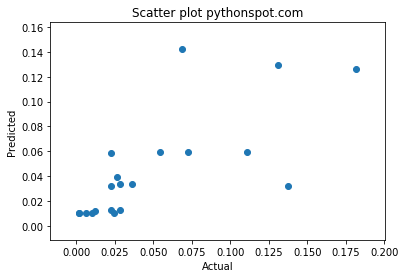

0.5092240087143749


In [9]:
X_train, y_train, X_test, y_test = split([2014], True)
X_train, y_train = get_only_positive(X_train, y_train)
X_test, y_test = get_only_positive(X_test, y_test)
m = ensemble.GradientBoostingRegressor(n_estimators=30, max_depth=3).fit(X_train, y_train)
y_predicted = m.predict(X_test)


plt.scatter(y_test, y_predicted)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
print(m.score(X_test, y_test))
# only countries with medals

In [10]:
from sklearn.metrics import r2_score

winter_old = get_w_r()
def year_predict(year):
    X_train, y_train, X_test, y_test = split([year], True)
    X_train, y_train = oversample(X_train, y_train)
    mR = linear_model.Ridge().fit(X_train, y_train)

    X_train, y_train, _, _ = split([year], False)
    X_train, y_train = oversample(X_train, y_train)

    m = ensemble.RandomForestClassifier().fit(X_train, y_train)
    y_predicted = m.predict_proba(X_test)


    THRESHOLD = 0.40
    y_pred = np.zeros(len(y_predicted))
    for i in range(len(y_predicted)):
        y_pred[i] = float(y_predicted[i][1] > THRESHOLD)
        if y_pred[i] > 0:
            y_pred[i] = mR.predict([X_test[i]])[0]

    sum_mult = float(winter_old[year].sum())
    plt.scatter(y_test*sum_mult, y_pred*sum_mult, alpha=0.3)
    plt.title('Scatter plot '  + str(year))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    print(r2_score(y_test, y_pred))

1320


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.386636459661286e-22 / 1.1102230246251565e-16
  RuntimeWarning)


1320


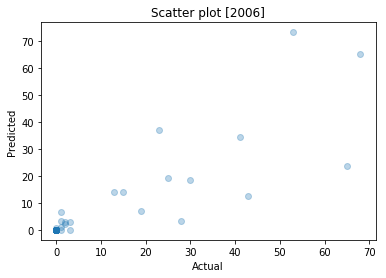

0.764352951583432


In [11]:
year_predict([2006])

1320


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.92176979877009e-22 / 1.1102230246251565e-16
  RuntimeWarning)


1320


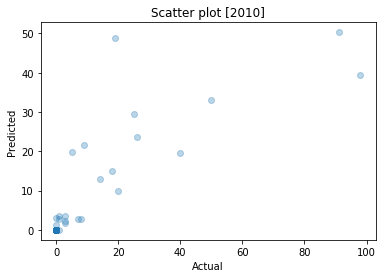

0.6984321704883429


In [12]:
year_predict([2010])

1320


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.223707564464393e-22 / 1.1102230246251565e-16
  RuntimeWarning)


1320


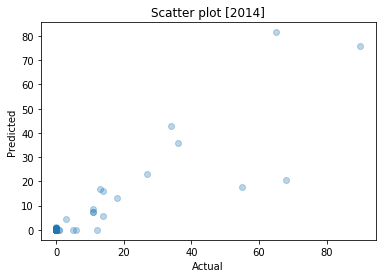

0.8085104783023883


In [13]:
year_predict([2014])